### SENTIMENT ANALYSIS PROJECT..
---

### Metrics Used and How Accuracy is measured.
The metrics used for the purpose of traning the model includes the following:
- Loss: This measures how well the model is performing during training. It is the differentce between the predicted output and the actual or ground truth output expected. In this, an average loss accrosss all items will be used for both training and validation.
        ````Loss = Expected Output - Predicted Output ````

- Accuracy: This meases how well the model is at correctly predicting the target output. Its the ratio of total correctly predicted labels against all labels present. During trainign and validation, average accuracy will be used.
        ```Accuracy = (Total Correct Predicted/ Total Labels)```
    
    
 - Beside above two metrics using during training and validation, In the process of evaluation, other metrics such as Confussion Matrixes (shows correct predictions and incorrect for each classes), f1 score, precision and recall scores will be used for evaluation. These variant methods are used in order to get better results.



 ### How Many data will be Suffient.
 - Since this is a binary classification, dataset around 100k records are enough.  
 - The dataset  will be used from this link:  https://zenodo.org/record/7552959

 - The data contains over 500k records which most of them i.e over 89% are positive labels while the rest are negative. In order to ensure the data is not huge and we can be able to run them on our machines, we will reduces and take only 25% of the postive labels and the rest all for negative labels to have a general total of about 189k records.

In [1]:
# !pip install --upgrade torch

In [2]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

import random
from tqdm import tqdm

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_warning()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### DATA: https://zenodo.org/record/7552959

In [4]:
!wget https://zenodo.org/record/7552959/files/prepared_clean_dataset.csv

--2023-09-03 20:57:43--  https://zenodo.org/record/7552959/files/prepared_clean_dataset.csv
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123162956 (117M) [text/plain]
Saving to: ‘prepared_clean_dataset.csv’

prepared_clean_data 100%[===================>] 117.46M  18.2MB/s    in 7.3s    

2023-09-03 20:57:52 (16.0 MB/s) - ‘prepared_clean_dataset.csv’ saved [123162956/123162956]



In [5]:
import os, re, glob

In [6]:
os.listdir("./")

['.config', 'prepared_clean_dataset.csv', 'sample_data']

In [7]:
# read the data
df = pd.read_csv("prepared_clean_dataset.csv")

In [8]:
# check sample data
df.sample(5)

,Unnamed: 0,Score,Sentiment,words
339196,342462,5.0,1,true mastergreat bandwell worth time classic j...
375084,378468,5.0,1,fun fantastic whimsical memorable characters i...
298926,300751,5.0,1,every episodes makes wonder creative writers m...
509611,514225,4.0,1,released chile mi uacute ltimo round tells sto...
438379,442943,5.0,1,i addicted show can wait second half season wi...


In [9]:
# drop the unamed column
df = df[["words","Score", "Sentiment"]].reset_index(drop=True)

In [10]:
# check the shape of the dataset
df.shape

(578419, 3)

In [11]:
# check NANS
df.isna().sum()

words        25
Score         0
Sentiment     0
dtype: int64

In [12]:
# drop all nulls
df.dropna(inplace=True)

In [13]:
# recheck nulls
df.isna().any()

words        False
Score        False
Sentiment    False
dtype: bool

In [14]:
# check the number of positve and negative sentiments
df.Sentiment.value_counts(normalize=True)

1    0.897011
0    0.102989
Name: Sentiment, dtype: float64

In [15]:
df['name'] = df['Sentiment'].map({1:"Positive Sentiments", 0:"Negative Sentiments"})

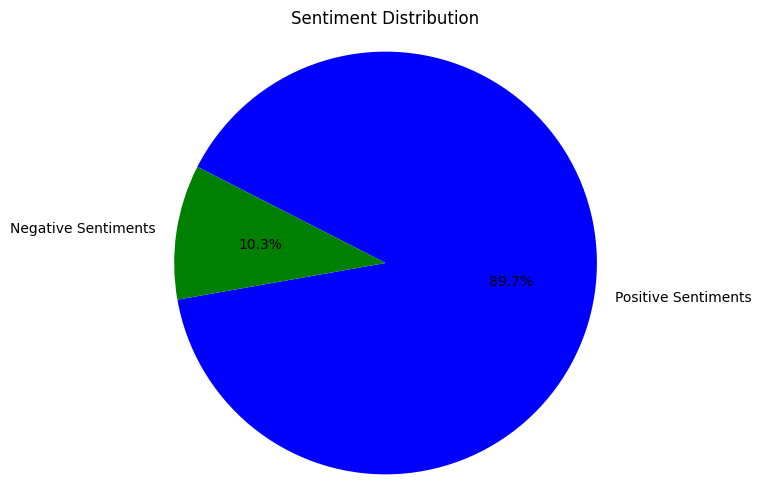

In [16]:
sentiment_counts = df.name.value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['blue', 'green']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=190)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()


In [17]:
518848*0.2

103769.6

In [18]:
# store old dataset copy
df_old = df.copy()

In [19]:
# to avoid overfitting, I will reduce the Postive sentiment by about 60%
# So here, among all the postive labels, I will take only 25% from it while all negative labels will be used/.

# at first am filtering all values for postive and getting 25% then concatinating will all values for negative labels
df = pd.concat([
    df[df['Sentiment'] ==1].sample(frac = 0.25, random_state=2023),
    df[df['Sentiment'] ==0]
], axis=0).sample(frac=1, random_state=23849).reset_index(drop=True)

In [20]:
# check new data shapes
df.shape

(189274, 4)

In [21]:
# rename the columns
df.columns = ['text', 'score', "label", "name"]

# recheck
df.head()

,text,score,label,name
0,my husband i love it interesting sometimes com...,5.0,1,Positive Sentiments
1,i avid ghost show watcher i tell show 8217 com...,1.0,0,Negative Sentiments
2,really cute wholesome family fare,5.0,1,Positive Sentiments
3,series twisted funny antics evil demons women ...,5.0,1,Positive Sentiments
4,i read preview notes took second realize play ...,3.0,1,Positive Sentiments


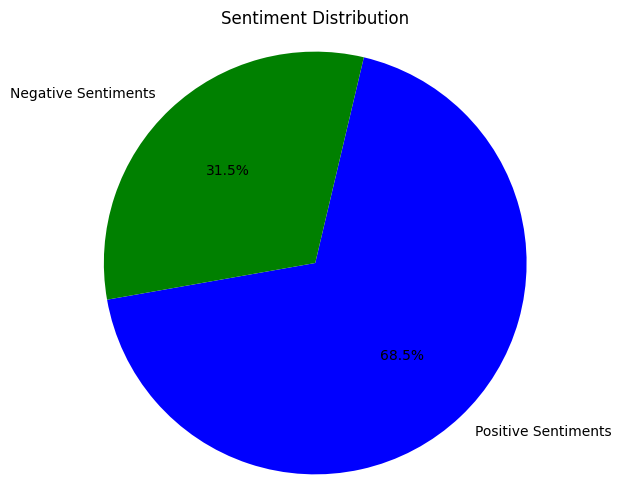

In [22]:
# repeat the pie chart
sentiment_counts = df.name.value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['blue', 'green']
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=190)
plt.axis('equal')
plt.title('Sentiment Distribution')
plt.show()


In [23]:
# check the scores distribution
df.score.value_counts()

5.0    94734
1.0    36237
4.0    24753
2.0    23331
3.0    10219
Name: score, dtype: int64

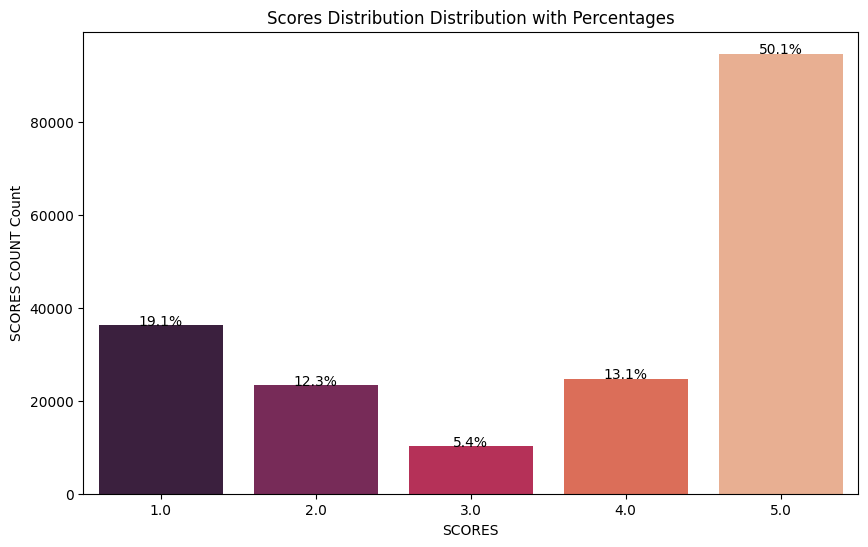

In [24]:
# plot bar for above
plt.figure(figsize=(10, 6))
# Create the bar plot
ax = sns.countplot(data=df, x='score', palette='rocket')
total = float(len(df))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 5,
            '{:.1f}%'.format((height / total) * 100),
            ha="center")

plt.xlabel('SCORES')
plt.ylabel('SCORES COUNT Count')
plt.title('Scores Distribution Distribution with Percentages')

plt.show()

### Modeling
- Start a simple BERT MODEL

In [25]:
import os
# Importing the os module to interact with the operating system.

os.environ['TOKENIZERS_PARALLELISM']='false'
# By setting it to 'false', it prevents the library from using multi-threading
# to parallelize tokenization. This can be useful to avoid multi-threading issues.

os.environ['CUDA_LAUNCH_BLOCKING']='1'
# This is a debugging aid for CUDA. When set to '1', it causes the CPU to wait
# until the GPU has completed its tasks. This is helpful for debugging as it.

os.environ['TORCH_USE_CUDA_DSA']='1'
# When set to '1', it causes the CPU to wait
# until the GPU has completed its tasks. This is helpful for debugging as it.


In [26]:
# encode sample sentence
# Import the pre-trained BERT model name 'bert-base-uncased'.
# This is a version of BERT that uses lowercase text and is one of the smaller BERT models.
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
bert_tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
sample_text = df.text[0]

encoding = bert_tokenizer.encode_plus(
    sample_text,
    max_length=32,
    add_special_tokens=True,
    padding=True,
    truncation=True,
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors='pt'
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [27]:
# output of encoder
encoding['input_ids']

tensor([[  101,  2026,  3129,  1045,  2293,  2009,  5875,  2823, 21699,  2467,
         11973,  2057,  2467, 11480,  3422,  2279,  2265,  2186,   102]])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


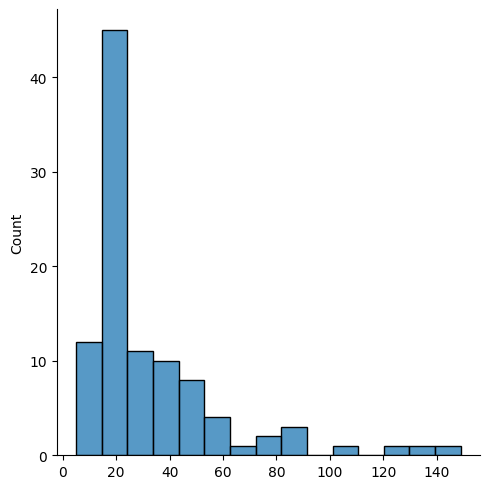

In [28]:
# check the token length distribution
token_lens = []
# Create a list to store the lengths of tokens for each text in the sample.

for txt in df.sample(100).text:
    token_lens.append(len(bert_tokenizer.encode(txt, max_length=512)))
# Tokenize the text using the BERT tokenizer.
# The 'encode' method converts the text into a sequence of token IDs.

sns.displot(token_lens)
# Plot a histogram of the token lengths using the seaborn library.

In [29]:
# get a sample df for fast training
# df_sample = df.sample(20000).reset_index(drop=True)

# get a sample df for fast training
df_sample = pd.concat(
    [df[df['label']==0], df[df['label']==1].sample(60000)]
).sample(frac=1).reset_index(
    drop=True
).sample(10000, random_state=2023).reset_index(drop=True)

### TEXTUAL CLEANING

In [30]:
# this function will be used to clean the text column above
# it get only words that are not stopwords and are of length over 3
#it also clean by removing some unwanted characters.

import nltk
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
# define lemmatizer object
word_lemmatizer = WordNetLemmatizer()
nltk.download('stopwords')
nltk.download('wordnet')


all_stopwords = set(stopwords.words('english'))
def process_textual_data(text):
    """
    Removes:
        stopwords, punctuations, and also lematizes
    """

    text = re.sub(r"\n", "", text)
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    words = text.split()
    words = [word_lemmatizer.lemmatize(w) for w in words if w not in all_stopwords and len(w)>3]
    return " ".join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [31]:
# apply the function on a sample text
df_sample.iloc[11]['text']

'doctor who best story lines television the relationship characters warms heart humor gentle monsters scary '

In [32]:
# process using the above function
process_textual_data(df_sample.iloc[11]['text'])

'doctor best story line television relationship character warms heart humor gentle monster scary'

In [33]:
# apply the data to the textual column for cleaning
df_sample['text_cleaned'] = df_sample['text'].apply(process_textual_data)

### Other Analysis of the selected data.

- In this case, we will perfom other analysis like plotting word cloud, plotting top n words and also summary of textual stats.

Text(0.5, 1.0, 'Length for the Reviews per record')

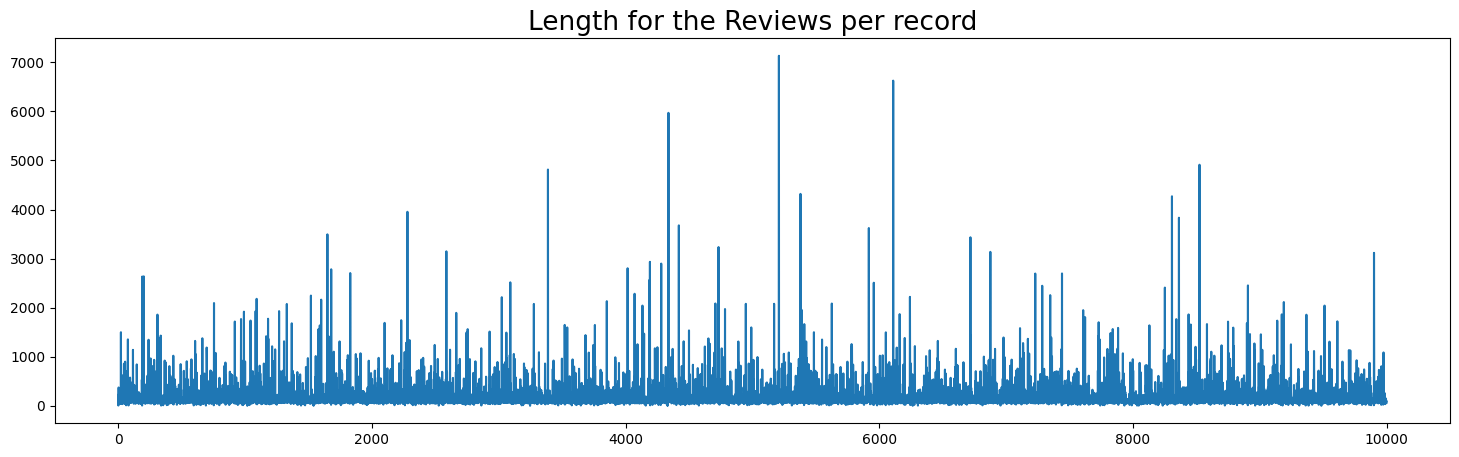

In [34]:
plt.figure(figsize=(18,5))
plt.plot(df_sample['text_cleaned'].apply(len))
plt.title("Length for the Reviews per record", fontsize=19,c='k')

### Observation.
- Most of the reviews are less than 1000 words with majority of them ranging between 200 words.
- There are some few reviews that has the longest count of over 6000 .

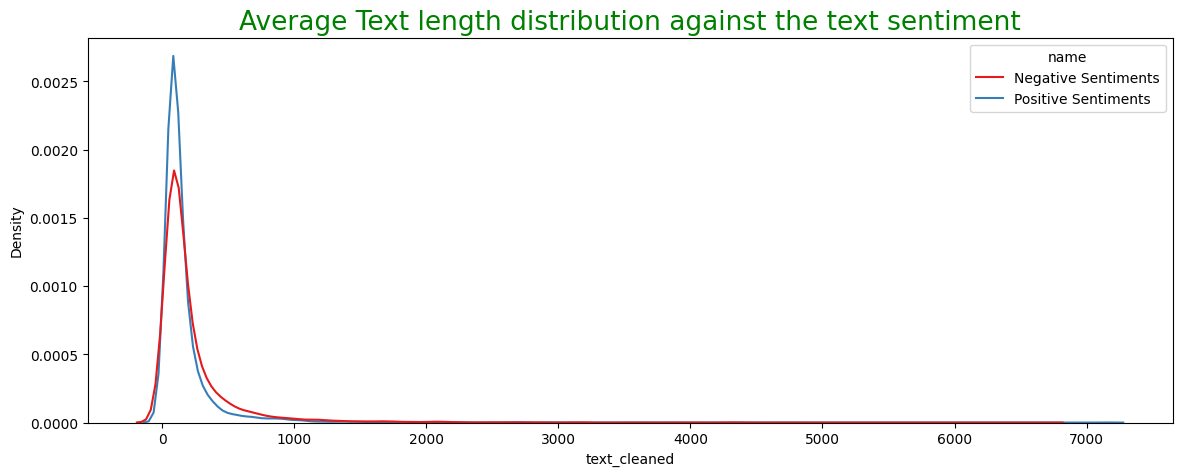

In [35]:
# average text length per record against the length
plt.figure(figsize=(14,5))
sns.kdeplot(x = df_sample['text_cleaned'].apply(len), hue=df_sample['name'], palette="Set1")
plt.title("Average Text length distribution against the text sentiment", fontsize=19, c='g')
plt.show()

### Observation.
- Interms of distribution of length as per label, both of them are rightly skewed i.e majority of the labels are found to the left while only few to the right hence making the tail to be on to the right.
- In this it also shows clearly that positive sentiments appears to have higher density at about 200 length when compaired to negatives sentiments.
- The textual reviews that appears to be longer are negative sentiments as it can be seen from above.

Labels   ['Negative Sentiments' 'Positive Sentiments']


Text(0.5, 0.98, 'DIstribution of Word Counts on different Reviews Sentiment ')

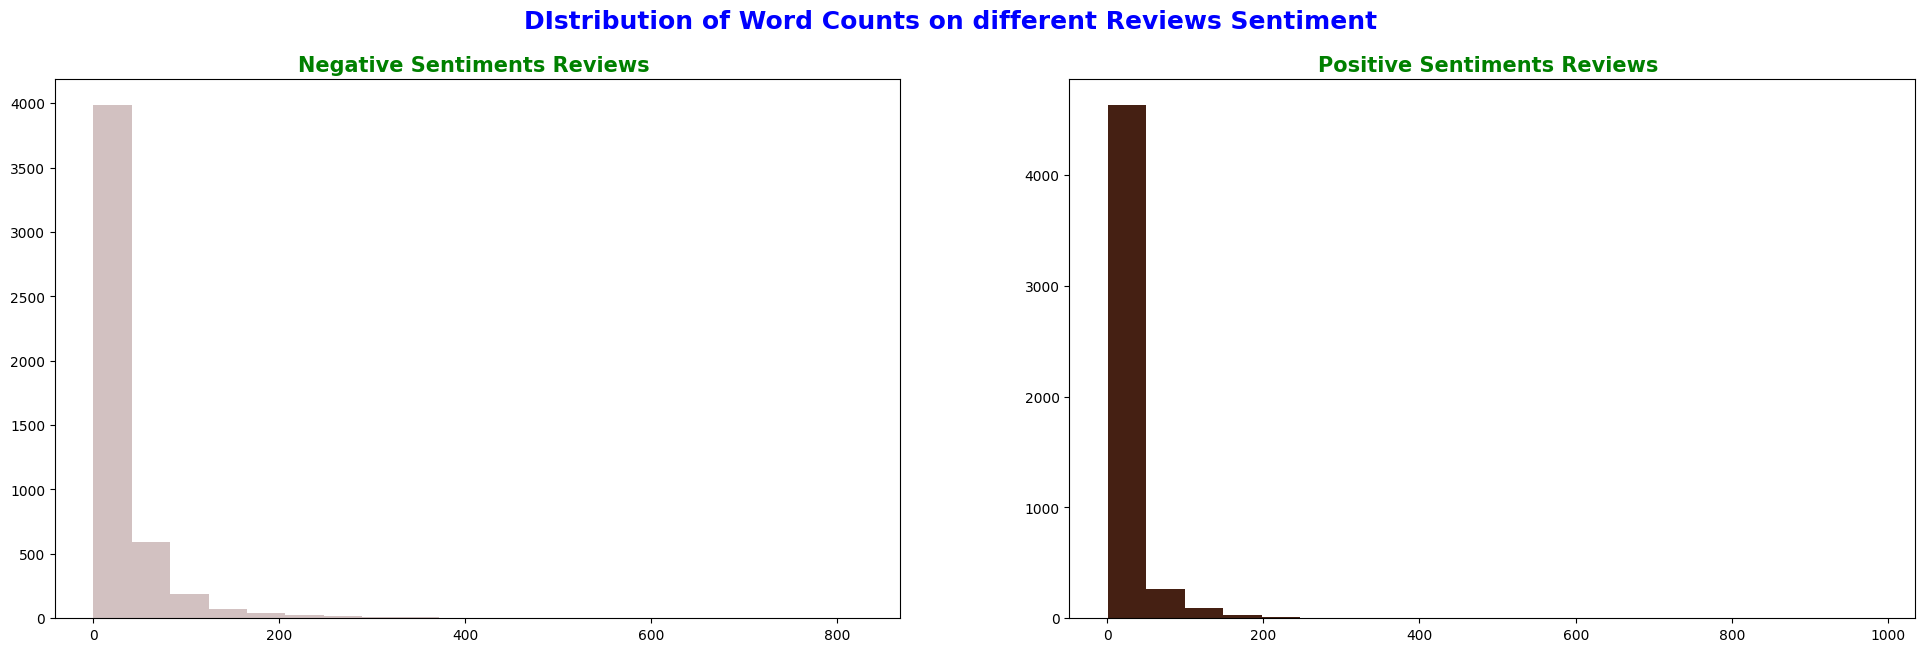

In [36]:
# plot the distribution to clearly represent above

curr_labels = df_sample['name'].unique()
print(f"Labels   {curr_labels}")
fig,ax= plt.subplots(1,len(curr_labels),figsize=(24,7))
colors = ["#d2c1c1",  "#452013"]
for i, each_label in enumerate(curr_labels):
    curr_data = df_sample[df_sample['name'] == each_label]['text_cleaned'].str.split().apply(len)
    ax[i].hist(curr_data, color = colors[i], bins=20)
    ax[i].set_title(f'{each_label} Reviews ', fontsize=15, c='g', fontweight='bold')

fig.suptitle("DIstribution of Word Counts on different Reviews Sentiment ", fontsize=18, c='b', fontweight='bold')

### Observation.
- This distribution proves what was observed above of most of the length being below 200. In this, it shows a higher concentration of words are between 0 and 50 words.

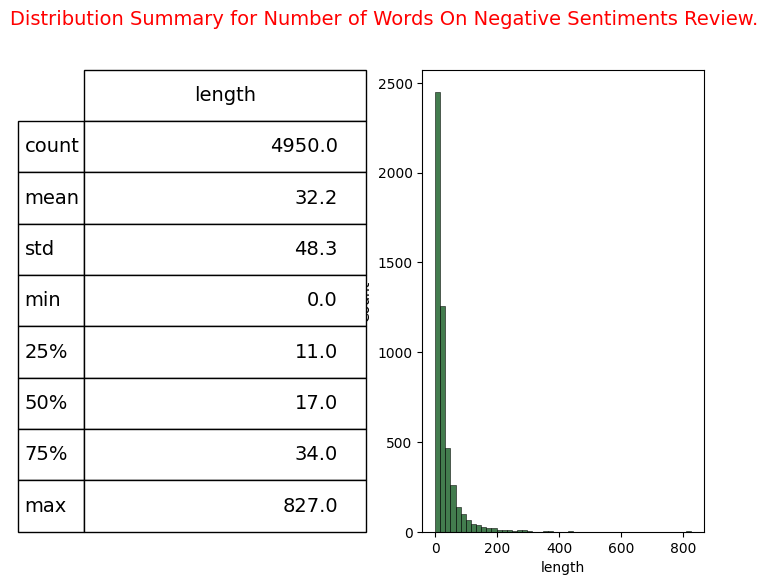

Negative Sentiments   Plotted




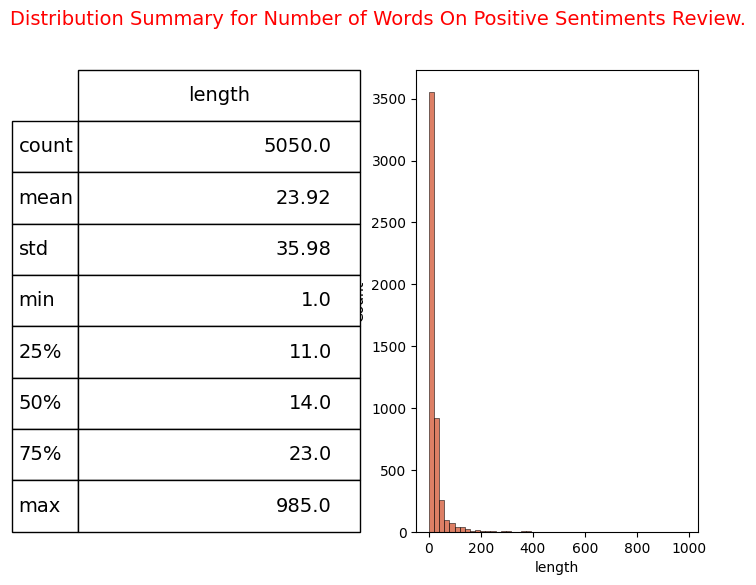

Positive Sentiments   Plotted




In [37]:
# plotting summary stats for the sentiments of reviews

def stats_summary_of_reviews(label , df , color):
    fig = plt.figure(figsize=(8,6))
    df['length'] = df["text_cleaned"].str.split().apply(len)
    ax1 = fig.add_subplot(122)
    sns.histplot(df[df['name']==label]['length'], ax=ax1 , color =color, bins=50)
    describe = df.length[df.name==label].describe().to_frame().round(2)

    ax2 = fig.add_subplot(121)
    ax2.axis('off')
    font_size = 14
    bbox = [0, 0, 1, 1]
    table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
    table.set_fontsize(font_size)
    fig.suptitle(f'Distribution Summary for Number of Words On {label} Review.', fontsize=14 , c ='r')
    plt.show()
    print(label, "  Plotted\n\n")

colors = ['#045012', "#d25432"]
# plot them
for i, lbl_name in enumerate(curr_labels):
    stats_summary_of_reviews(lbl_name, df_sample, f"{colors[i]}")

### Observation.
- For Positive reviews:
    - The maximum length of words in a review is 985. It has an average of 14 words with a quite higher standard deviation of about 36 means from record to records, there is about a shift of 36 words.
    - Its distribution is also skewed to the right
- For negative reviews:
    - It has a lower standard deviation when compaired to positive reviews.
    - Its average word count is about 17 with the highest having 827.
    - This shows that most of the negative reviews were much longer than postive reviews as it can be proved by average length and standard deviation.

In [38]:
# plotting word clouds

from collections import Counter
import wordcloud as wc
def generate_wordcloud_plot(text_strings , title, max_words):
    """
    create a word cloud plot
    """
    word_cloud = wc.WordCloud(
        background_color="white"
        ,margin=20,
        width=900,
        height=700,
        prefer_horizontal=0.75,
        max_words=max_words,
        scale=2

    )
    #genererate
    word_cloud.generate_from_frequencies(dict(Counter(text_strings)))
    plt.figure(figsize=(14,8))
    plt.title(f"Top {max_words} {title} " , fontsize=17 , c='r')
    plt.imshow(word_cloud)
    plt.show()

In [39]:
# " ".join(df_sample[df_sample['label'] ==1]['text_cleaned'].tolist()).split()

In [40]:
# text the text for both positive and negative
positive_tokens = " ".join(df_sample[df_sample['label'] ==1]['text_cleaned'].tolist()).split()
negative_tokens = " ".join(df_sample[df_sample['label'] ==0]['text_cleaned'].tolist()).split()



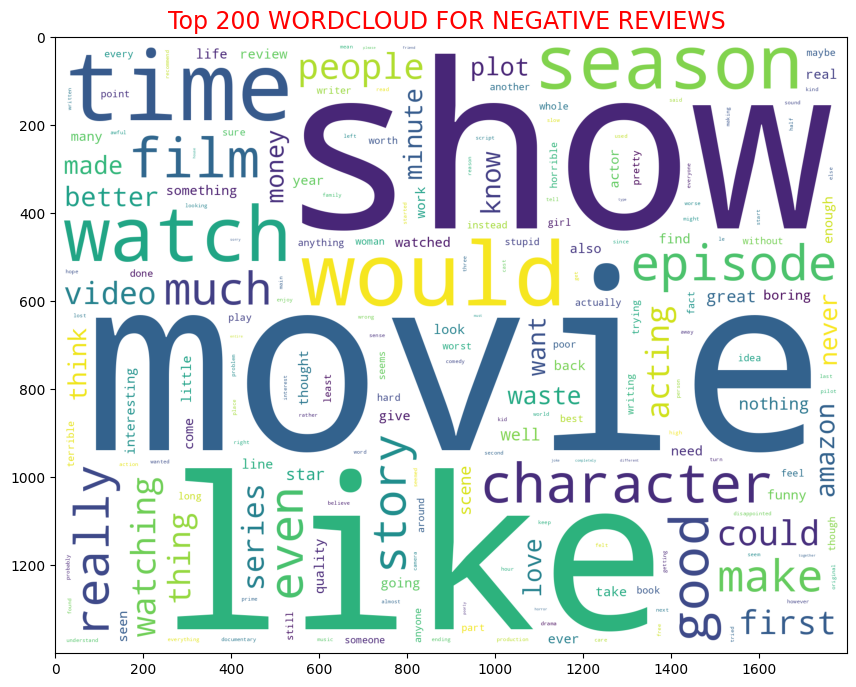

In [41]:
# show the top 200 words from the comments with Negative Reviews
generate_wordcloud_plot(negative_tokens , "WORDCLOUD FOR NEGATIVE REVIEWS", 200)

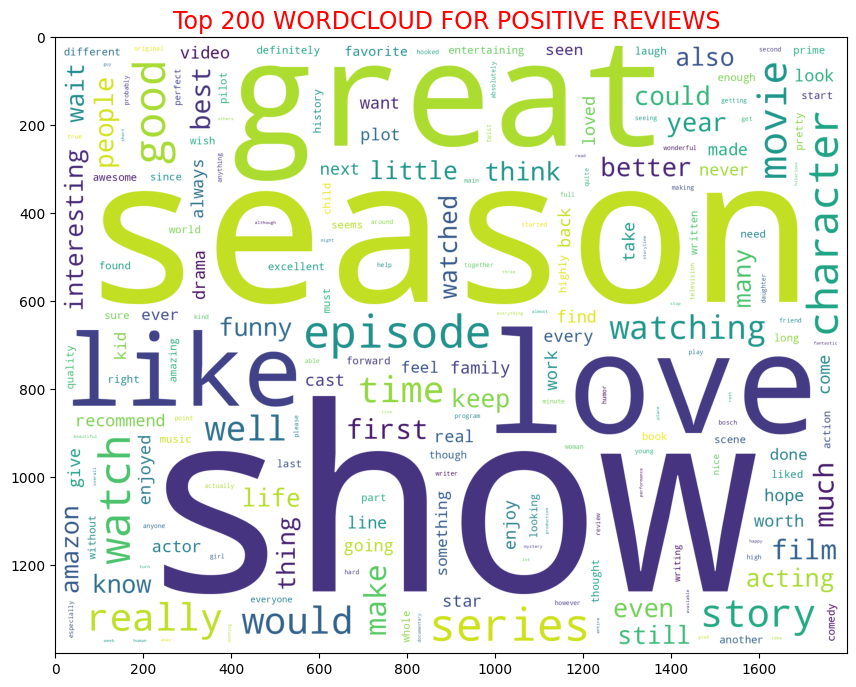

In [42]:
# show the top 200 words from the comments with positve Reviews
generate_wordcloud_plot(positive_tokens , "WORDCLOUD FOR POSITIVE REVIEWS", 200)

### Continuing with Machine learning

In [43]:
# divide data into train (60%), val (20%), test (20%)
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df_sample.text.values,
    df_sample.label.values,
    test_size=.4,
    random_state=RANDOM_SEED)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test,
    y_val_test,
    test_size=.5,
    random_state=RANDOM_SEED)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((6000,), (6000,), (2000,), (2000,), (2000,), (2000,))

### BERT Sentiment Analysis

- BERT(Bidirectional Encoder Representations from Transformers) is a pre-trained language model that can be fine tuned to perform NLP task. Bidirectional means that the model is able to read text from both left-to-right and from right-to-left. This capability helps it to understand context. It can be able to understand over 100 languages as at now.
- Several pretrained are present and are dependent on the size of weights. These are;
    - bert-base-uncased
    - bert-base-cased
    - bert-large-uncased
    - bert-large-cased
    - bert-base-multilingual-uncased
    - bert-base-multilingual-cased
- uncased - All text was converted to lower case before training the model.
- cased - The text used to train the model was not converted to lower case.


#### ::: PAPER {https://arxiv.org/pdf/1810.04805.pdf}


- It normally expect input sentences to be formatted as a list of tokens.
- During training the model replaces each token with a corresponding word embedding vector.
- Each word vector has a length of 768. The max input length for BERT is 512 tokens.

- The input can have the following:
    - input_ids (type: torch tensor)
    - token_type_ids (type: torch tensor)
    - attention_mask (type: torch tensor)
    - labels (type: torch tensor)
    
# 1. input_ids
- The input_ids are the sentence or sentences represented as tokens.There are a few BERT special tokens that one needs to take care of:
    -  [CLS] - Classifier token, value: 101
    -  [SEP] - Separator token, value: 102
     - [PAD] - Padding token, value: 0

-  It  expects every row in the input_ids to have the special tokens included as follows:

# 2. token_type_ids
- Token_type_ids are used when there are two sentences that need to be part of the input.  The token type ids indicate which tokens are part of sentence1 and which are part of sentence2.

# 3. attention_mask
-  The attention mask has the same length as the input_ids.
- It tells the model which tokens in the input_ids are words and which are padding. 1 indicates a word (or special token) and 0 indicates padding.

# 4. labels
- The label (target) for each row in the input_ids.  The labels are integers representing each target class e.g. 1, 2, 3 etc.

---

- The textual dataset will be tokenized by of the model's tokenizer so that we can extract input ids and attention mask

In [44]:
# set parameter
MAX_LEN = 128
BATCH_SIZE = 16
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
lr_rate = 2e-5
EPOCH = 7
num_classes = 2

In [45]:
# create dataset
class SentimentDataset(Dataset):
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self,idx):
        sentence = self.text[idx]
        # encode input tex
        encoding = self.tokenizer.encode_plus(
            sentence,
            max_length=self.max_len,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        return {
            'input_ids': torch.squeeze(encoding['input_ids'],dim=0),
            'attention_mask': torch.squeeze(encoding['attention_mask'],dim=0),
            'targets': torch.tensor(self.target[idx],dtype=torch.long)
        }

In [46]:
from tensorflow.keras.utils import to_categorical
# create dataloader
train_dataset_bert = SentimentDataset(
    X_train, to_categorical(y_train),
    bert_tokenizer, MAX_LEN
)
train_dataloader_bert = DataLoader(train_dataset_bert,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset_bert = SentimentDataset(
    X_val, to_categorical(y_val),
    bert_tokenizer, MAX_LEN
)
val_dataloader_bert = DataLoader(val_dataset_bert,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset_bert = SentimentDataset(
    X_test, to_categorical(y_test),
    bert_tokenizer, MAX_LEN
)

In [47]:
# check the output of dataloader
next(iter(train_dataset_bert))

{'input_ids': tensor([  101,  1045,  2047,  6687,  3352, 19056,  3528,  2336,  4730,  2800,
          1045,  2428,  5632,  2265,  2052,  2066,  2156,  1045,  2228,  2759,
          3920,  2336,  1045,  2245,  4036, 15902, 10800,  5966, 12014,  2893,
          2242,  2589,  2551,  2362,  2023,  2828,  2265,  1045,  2052,  2215,
          2402,  2684,  3422,  1045, 16755,  2814,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [48]:
# create classifier
class BertSentimentClassifier(nn.Module):
    def __init__(self,n_classes):
        super(BertSentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask,return_dict = False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [49]:
# REF:  https://bhashkarkunal.medium.com/pytorch-tutorial-from-basic-to-advance-level-a-numpy-replacement-and-deep-learning-framework-that-a3c8dcf9a9d4
#       https://www.exxactcorp.com/blog/Deep-Learning/advanced-pytorch-lightning-using-torchmetrics-and-lightning-flash

# function to calculate average
class Metrics(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.loss, self.acc = 0, 0
        self.avg_loss, self.avg_acc = 0, 0
        self.sum_loss, self.sum_acc = 0, 0
        self.count = 0

    def update(self, loss, acc, n=1):
        self.loss, self.acc = loss, acc
        self.sum_loss += loss * n
        self.sum_acc += acc * n
        self.count += n
        self.avg_loss, self.avg_acc = self.sum_loss / self.count, self.sum_acc / self.count

# function to calculate accuracy
def check_acc(preds, labels):
    correct = 0
    for pred, label in zip(preds, labels):
        if pred == label:
            correct += 1
    return correct/len(preds)

# function to record loss & accuracy
class Log(object):
    def __init__(self):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
    def append(self, train, val):
        self.train_loss.append(train.avg_loss)
        self.train_accuracy.append(train.avg_acc)
        self.val_loss.append(val.avg_loss)
        self.val_accuracy.append(val.avg_acc)

In [50]:
# train function
def train_fn(data_loader, model, optimizer, criterion,device, epoch):
    model.train()

    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device).long()
        attention_mask = attention_mask.to(device).long()
        targets = targets.to(device)
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)


        # calculate loss
        optimizer.zero_grad()
        loss = criterion(outputs.float(), targets.float())
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets.argmax(axis=1))
        # update weights
        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

# val function
def eval_fn(data_loader, model,criterion,device, epoch):
    model.eval()

    metrics = Metrics()
    tk0 = tqdm(data_loader, total=len(data_loader))
    for step, inputs in enumerate(tk0):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        targets = inputs['targets']
        input_ids = input_ids.to(device).long()
        attention_mask = attention_mask.to(device).long()
        targets = targets.to(device)

        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        # calculate loss
        loss = criterion(outputs.float(), targets.float())
        preds = torch.argmax(outputs,dim=1)
        accuracy = check_acc(preds,targets.argmax(axis=1))

        # save loss value
        metrics.update(loss.item(),accuracy, BATCH_SIZE)
        tk0.set_postfix(loss=metrics.avg_loss,accuracy=metrics.avg_acc, epoch=epoch+1)
    return metrics

In [51]:
device

device(type='cuda')

In [52]:
torch.optim.Adam



torch.optim.adam.Adam

In [53]:
def run(clf,train_dataloader, val_dataloader, model_name):
    # Load pretrained model
    model = clf
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr_rate)
    # Set loss function
    criterion = nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, 'min')
    best_loss = 10**5
    log = Log()
    for epoch in range(0,EPOCH):
        train_metrics = train_fn(train_dataloader, model, optimizer, criterion, device, epoch)
        val_metrics = eval_fn(val_dataloader, model, criterion, device, epoch)
        log.append(train_metrics,val_metrics)
        scheduler.step(val_metrics.avg_loss)
        # Check if val_loss is less than best_loss
        if val_metrics.avg_loss < best_loss:
            # Update best loss
            best_loss = val_metrics.avg_loss
            # Save model
            torch.save(model.state_dict(), f'{model_name}_best.pth')
    return log

In [54]:
print("continue")

continue


In [55]:
BERT_MODEL = BertSentimentClassifier(num_classes)
log = run(BERT_MODEL,train_dataloader_bert,val_dataloader_bert, "BERT")

100%|██████████| 125/125 [00:17<00:00,  7.29it/s, accuracy=0.849, epoch=7, loss=0.579]


In [56]:
log.train_loss,log.val_loss

([0.60533269516627,
  0.5785329806009928,
  0.5639499546686808,
  0.5582187272707622,
  0.5586094234784444,
  0.5633798734347025,
  0.5547554577191671],
 [0.594263750076294,
  0.6058645572662353,
  0.5836162786483765,
  0.5868045306205749,
  0.5957816939353943,
  0.5989648432731628,
  0.5791190910339356])

In [57]:
log.train_accuracy,log.val_accuracy

([0.8036666666666666,
  0.8488333333333333,
  0.8781666666666667,
  0.8898333333333334,
  0.8886666666666667,
  0.879,
  0.8965],
 [0.8185, 0.792, 0.8375, 0.833, 0.814, 0.8075, 0.8485])

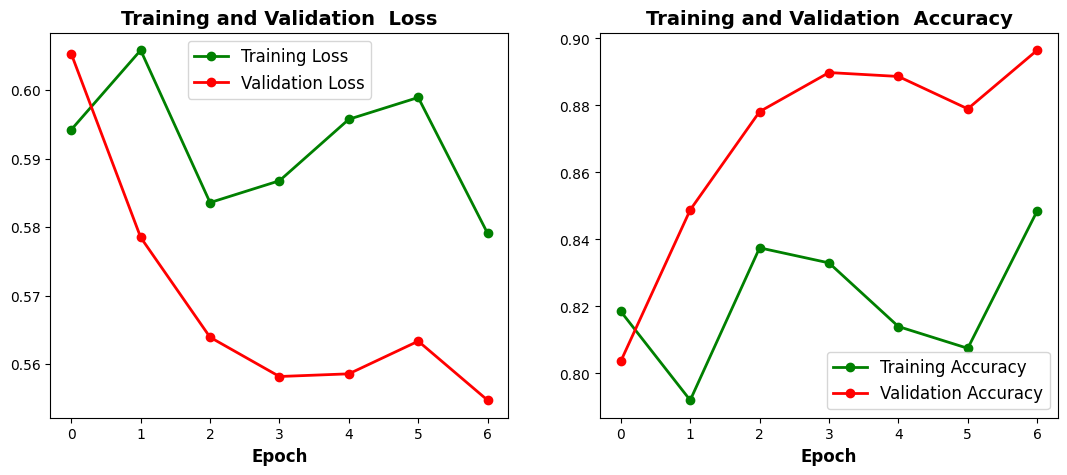

In [58]:
fig, axs = plt.subplots(1,2,figsize=(13,5))

def plot_log(ax, train_value, val_value, label):
    ax.plot(val_value,f'go-', label=f'Training {label}', linewidth=2)
    ax.plot(train_value,f'ro-', label=f'Validation {label}', linewidth=2)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_title(f'Training and Validation  {label}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=12)


plot_log(axs[0],log.train_loss,log.val_loss,'Loss')
plot_log(axs[1],log.train_accuracy,log.val_accuracy,'Accuracy')

In [59]:
# load weight with best val loss
model_bert = BertSentimentClassifier(num_classes)
model_bert.load_state_dict(torch.load('./BERT_best.pth'))

<All keys matched successfully>

In [60]:
# test function
def test_fn(dataset, model, device):
    model = model.to(device)
    model.eval()

    labels = []
    probs =[]
    predictions = []
    tk0 = tqdm(dataset, total=len(dataset))
    for step, inputs in enumerate(tk0):
        input_ids = torch.unsqueeze(inputs['input_ids'],dim=0)
        attention_mask = torch.unsqueeze(inputs['attention_mask'],dim=0)
        targets = torch.unsqueeze(inputs['targets'],dim=0)
        input_ids = input_ids.to(device).long()
        attention_mask = attention_mask.to(device).long()
        targets = targets.to(device)
        # make prediction
        outputs = model(input_ids=input_ids,
                       attention_mask=attention_mask)
        pred = torch.argmax(outputs,dim=1)

        labels.append(targets.argmax(axis=1).item())
        predictions.append(pred.item())
        probs.append(outputs.tolist()[0])
    return labels, predictions, probs

In [61]:
torch.cuda.empty_cache()

In [62]:
# predict test dataset
labels_bert, preds_bert, probs_bert = test_fn(test_dataset_bert, model_bert, device)

100%|██████████| 2000/2000 [01:04<00:00, 31.06it/s]


In [63]:
np.array(probs_bert).max(1)

array([0.99995863, 0.99997115, 0.99996197, ..., 0.99996901, 0.99996471,
       0.99996102])

In [64]:
print(f'Label\t\t:{labels_bert[:10]}')
print(f'Prediction\t:{preds_bert[:10]}')
print(f"Probs \t {np.array(probs_bert).max(1)[:10]}")

Label		:[0, 1, 0, 1, 1, 1, 0, 0, 0, 1]
Prediction	:[0, 1, 0, 1, 1, 1, 0, 0, 0, 1]
Probs 	 [0.99995863 0.99997115 0.99996197 0.99994063 0.99997282 0.99996185
 0.99997449 0.99996412 0.99995267 0.99997067]


In [65]:
LABELS = ["NEGATIVE", "POSITIVE"]

Accuracy Score is  0.829000
F1 Score is  0.810000
Recall Score is  0.730461
Precision Score is  0.9089775561097256


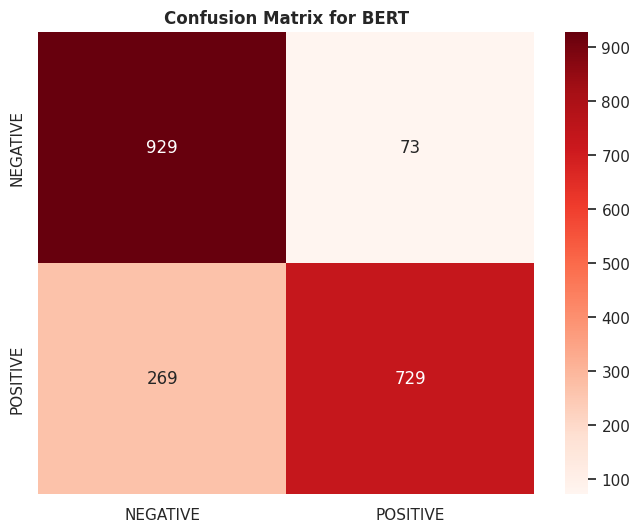

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
!pip install scikit-plot
import scikitplot as skplt
def print_model_perfomance(labels, preds, model_name):
    print("Accuracy Score is  {:4f}".format(accuracy_score(labels, preds)))
    print("F1 Score is  {:4f}".format(f1_score(labels, preds)))
    print("Recall Score is  {:4f}".format(recall_score(labels, preds)))
    print("Precision Score is  {:4}".format(precision_score(labels, preds)))
    # visualize predictions
    sns.set_theme(style='whitegrid',rc={'figure.figsize':(8,6)})
    plt.title(f"Confusion Matrix for {model_name}", fontweight="bold")
    cf_matrix = confusion_matrix(labels, preds)
    sns.heatmap(cf_matrix,annot=True,cmap='Reds',fmt="g",xticklabels=LABELS,yticklabels=LABELS);


print_model_perfomance(labels_bert, preds_bert, "BERT")

In [67]:
# get classification reports
preds1 = pd.Series(preds_bert).map({1:"Positive", 0:"Negative"})
labels1 = pd.Series(labels_bert).map({1:"Positive", 0:"Negative"})


In [68]:
print(classification_report(labels1,preds1))

              precision    recall  f1-score   support

    Negative       0.78      0.93      0.84      1002
    Positive       0.91      0.73      0.81       998

    accuracy                           0.83      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.84      0.83      0.83      2000



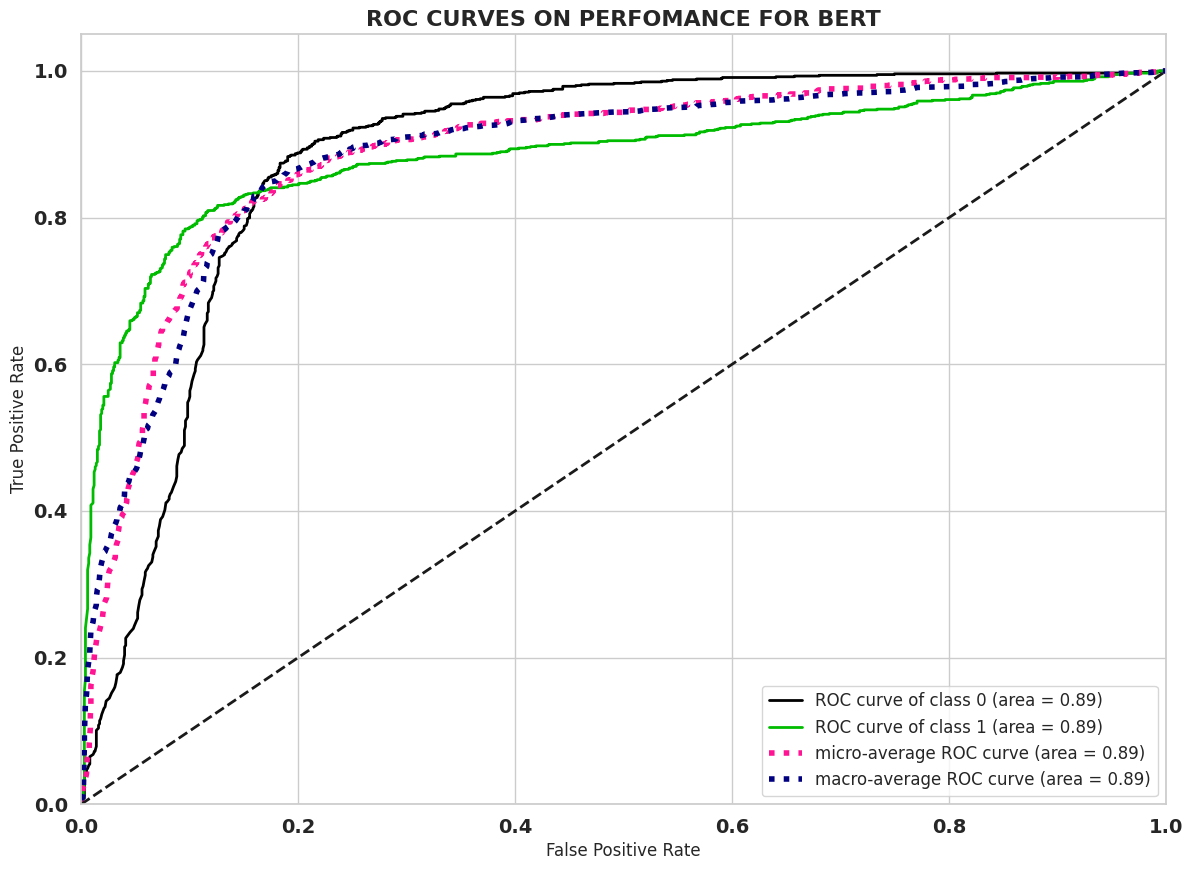

In [69]:
# we will plot the ROC CURVES
def plot_roc_curves(actual_labels, preds_proba, model_name):
    skplt.metrics.plot_roc(np.array(actual_labels), preds_proba, figsize=(14, 10))
    plt.title(f"ROC CURVES ON PERFOMANCE FOR {model_name}",fontsize=16, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.show()

plot_roc_curves(labels_bert, probs_bert, "BERT")

### ROBERTA Model.

- It is build based on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.
- The data and format of training is similar to bert

In [70]:
# First prepare the tokenizer
ROBERTA_PRETRAINED_NAME ='roberta-base'
roberta_tokenizer = transformers.RobertaTokenizerFast.from_pretrained('roberta-base')
# config for the model
model_config = transformers.RobertaConfig.from_pretrained(ROBERTA_PRETRAINED_NAME)
model_config.output_hidden_states = True



# we then prepare the same dataset as we did for BERT.. But in this case we use ROBERTA TOKENIZER

# create dataloader
train_dataset_roberta = SentimentDataset(
    X_train, to_categorical(y_train),
    roberta_tokenizer, MAX_LEN
)
train_dataloader_roberta = DataLoader(train_dataset_roberta,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset_roberta = SentimentDataset(
    X_val, to_categorical(y_val),
    roberta_tokenizer, MAX_LEN
)
val_dataloader_roberta = DataLoader(val_dataset_roberta,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset_roberta = SentimentDataset(
    X_test, to_categorical(y_test),
    roberta_tokenizer, MAX_LEN
)


In [71]:
len(y_val), X_val.shape, y_train.shape, X_train.shape, MAX_LEN

(2000, (2000,), (6000,), (6000,), 128)

- Lets now Define ROberta Model..

In [72]:
class RobertaSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(RobertaSentimentClassifier, self).__init__()
        self.roberta = transformers.RobertaModel.from_pretrained(ROBERTA_PRETRAINED_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.roberta.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        output = self.drop(pooled_output)
        output = self.out(output)
        return self.softmax(output)

In [73]:
import gc

gc.collect()
torch.cuda.empty_cache()



In [74]:
# torch.cuda.empty_cache()
ROBERTA_MODEL = RobertaSentimentClassifier(num_classes)
log2 = run(ROBERTA_MODEL, train_dataloader_roberta, val_dataloader_roberta, "ROBERTA")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [00:15<00:00,  7.85it/s, accuracy=0.834, epoch=7, loss=0.585]


In [75]:
# ROBERTA_MODEL.to(device)

In [76]:
log2.train_loss,log2.val_loss

([0.68913796154658,
  0.5926396555900574,
  0.5768408306439717,
  0.6170279417037964,
  0.6345150922139485,
  0.5854197923342387,
  0.5676303313573201],
 [0.5956233944892884,
  0.5969244303703308,
  0.5715711207389832,
  0.6698674340248107,
  0.7048304204940796,
  0.5857551541328431,
  0.5852727131843567])

In [77]:
log2.train_accuracy,log2.val_accuracy

([0.6276666666666667,
  0.8188333333333333,
  0.8513333333333334,
  0.772,
  0.7365,
  0.8345,
  0.867],
 [0.8135, 0.813, 0.864, 0.6635, 0.5895, 0.831, 0.834])

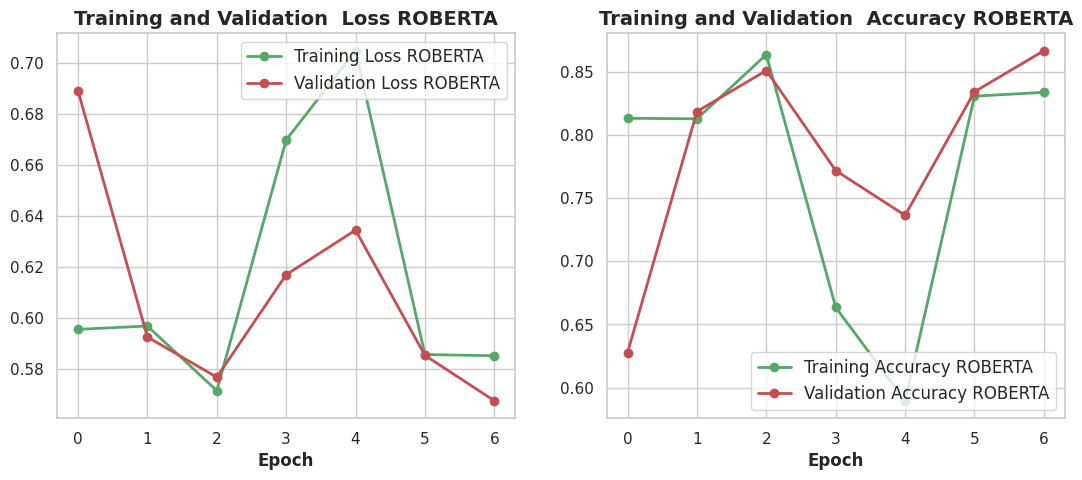

In [78]:
fig, axs = plt.subplots(1,2,figsize=(13,5))
plot_log(axs[0],log2.train_loss,log2.val_loss,'Loss ROBERTA')
plot_log(axs[1],log2.train_accuracy,log2.val_accuracy,'Accuracy ROBERTA')

In [79]:
# load the wiehgts for roberta
model_roberta = RobertaSentimentClassifier(num_classes)
model_roberta.load_state_dict(torch.load('./ROBERTA_best.pth'))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [80]:
# lets get the predictions
labels_roberta, preds_roberta, probs_roberta = test_fn(test_dataset_roberta, model_roberta, device)

100%|██████████| 2000/2000 [01:00<00:00, 32.89it/s]


Accuracy Score is  0.847500
F1 Score is  0.848635
Recall Score is  0.856713
Precision Score is  0.8407079646017699


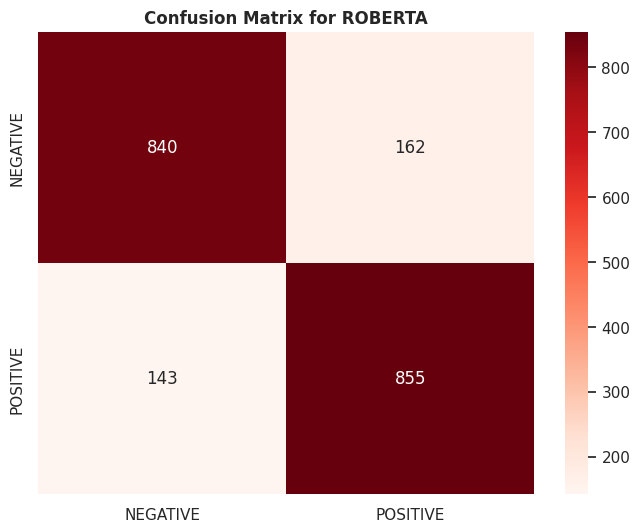

In [81]:
# print the perfomance
print_model_perfomance(labels_roberta, preds_roberta, "ROBERTA")

In [82]:
# print classification report
print(classification_report(
    pd.Series(preds_roberta).map({1:"Positive", 0:"Negative"}),
    pd.Series(labels_roberta).map({1:"Positive", 0:"Negative"}))
     )

              precision    recall  f1-score   support

    Negative       0.84      0.85      0.85       983
    Positive       0.86      0.84      0.85      1017

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



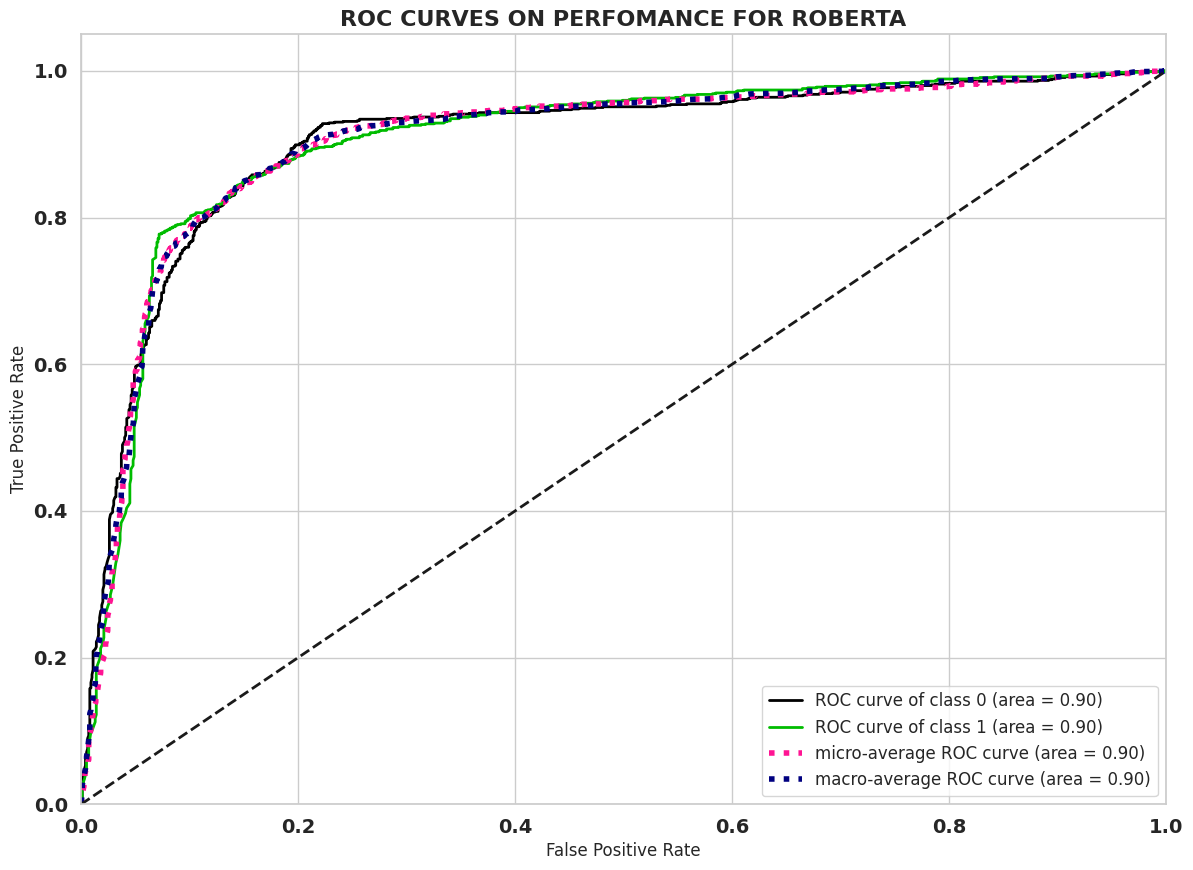

In [83]:
plot_roc_curves(labels_roberta, probs_roberta, "ROBERTA")

### XLNET model

- XLnet is an extension of the Transformer-XL model pre-trained using an autoregressive method to learn bidirectional contexts by maximizing the expected likelihood over all permutations of the input sequence factorization order.
- We randomly remove some tokens in input data and we try to predict these removed tokens. mt is a mask that is 1 when a token is removed 1 elsewhere. Pretraining the model with this task helps learn patterns data and the model performs well in downstream tasks using the learned parameters.


- The inputs are same as that of BERT except its output is jsut the predictions only, here is the implimentation.

---

In [84]:
# we define all the data required for it first
# First prepare the tokenizer
XLNET_PRETRAINED_NAME ='xlnet-base-cased'
xlnet_tokenizer = transformers.AutoTokenizer.from_pretrained(XLNET_PRETRAINED_NAME)

# THe preparation of the dataset is same for all since they are transfomers of same origin
train_dataset_xlnet = SentimentDataset(
    X_train, to_categorical(y_train),
    xlnet_tokenizer, MAX_LEN
)
train_dataloader_xlnet = DataLoader(train_dataset_xlnet,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

val_dataset_xlnet = SentimentDataset(
    X_val, to_categorical(y_val),
    xlnet_tokenizer, MAX_LEN
)
val_dataloader_xlnet = DataLoader(val_dataset_xlnet,
                             batch_size=BATCH_SIZE,
                             num_workers=2)

test_dataset_xlnet = SentimentDataset(
    X_test, to_categorical(y_test),
    xlnet_tokenizer, MAX_LEN
)


In [85]:
# define XLNET model
class XLNetSentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(XLNetSentimentClassifier, self).__init__()
        #self.xlnet = transformers.XLNetModel.from_pretrained(XLNET_PRETRAINED_NAME)
        self.xlnet = transformers.AutoModelForSequenceClassification.from_pretrained(XLNET_PRETRAINED_NAME, num_labels=n_classes)
        #self.drop = nn.Dropout(p=0.3)
        #self.out = nn.Linear(self.xlnet.config.hidden_size, n_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.xlnet(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        #print(len(pooled_output)
        out_re = pooled_output[0]
        #output = self.drop(pooled_output)
        #output = self.out(output)
        return self.softmax(out_re)


In [86]:
# train xlnet model
torch.cuda.empty_cache()
gc.collect()
XLNET_MODEL = XLNetSentimentClassifier(num_classes)
log_xlnet = run(XLNET_MODEL, train_dataloader_xlnet, val_dataloader_xlnet, "XLNET_MODEL")

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [00:24<00:00,  5.18it/s, accuracy=0.767, epoch=7, loss=0.619]


In [87]:
print()

In [88]:
log_xlnet.train_loss,log_xlnet.val_loss

([0.6198546334902445,
  0.5818919345537822,
  0.5758287132581075,
  0.5783460623423259,
  0.5608369104067484,
  0.5636886118253072,
  0.5820514310201009],
 [0.5959431734085083,
  0.5757532525062561,
  0.5854801521301269,
  0.5760345892906189,
  0.5785300340652466,
  0.5953471913337708,
  0.619491527557373])

In [89]:
log_xlnet.train_accuracy,log_xlnet.val_accuracy

([0.7683333333333333,
  0.8408333333333333,
  0.8541666666666666,
  0.8486666666666667,
  0.8833333333333333,
  0.8783333333333333,
  0.8421666666666666],
 [0.816, 0.853, 0.835, 0.852, 0.85, 0.816, 0.7675])

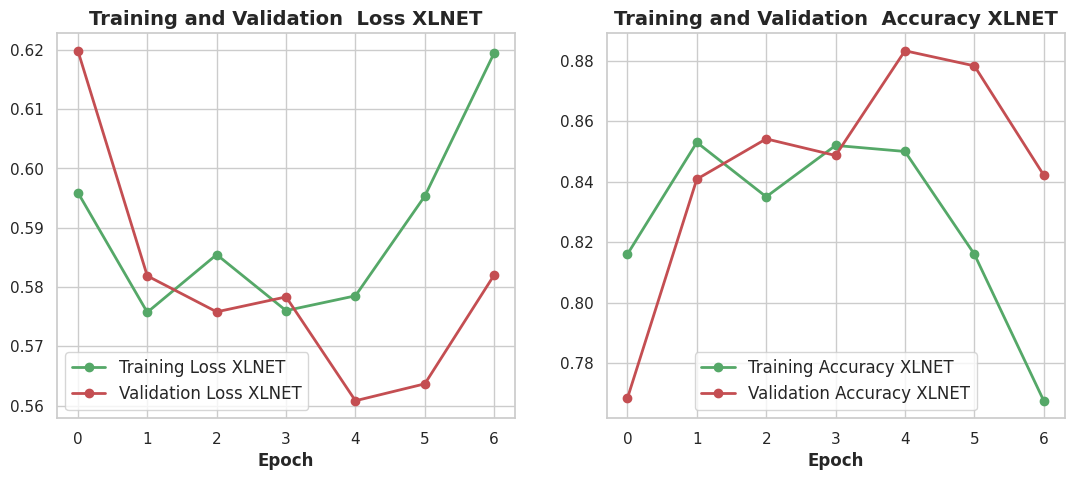

In [90]:
# plot the results of XLNET
fig, axs = plt.subplots(1,2,figsize=(13,5))
plot_log(axs[0],log_xlnet.train_loss,log_xlnet.val_loss,'Loss XLNET')
plot_log(axs[1],log_xlnet.train_accuracy,log_xlnet.val_accuracy,'Accuracy XLNET')

In [91]:
# load the models weights for xlnet
model_xlnet = XLNetSentimentClassifier(num_classes)
model_xlnet.load_state_dict(torch.load('./XLNET_MODEL_best.pth'))

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

In [92]:
# lets get the perfomance for XLNET model
labels_xlnet, preds_xlnet, probs_xlnet = test_fn(test_dataset_xlnet, model_xlnet, device)

100%|██████████| 2000/2000 [01:21<00:00, 24.63it/s]


Accuracy Score is  0.843000
F1 Score is  0.840932
Recall Score is  0.831663
Precision Score is  0.8504098360655737


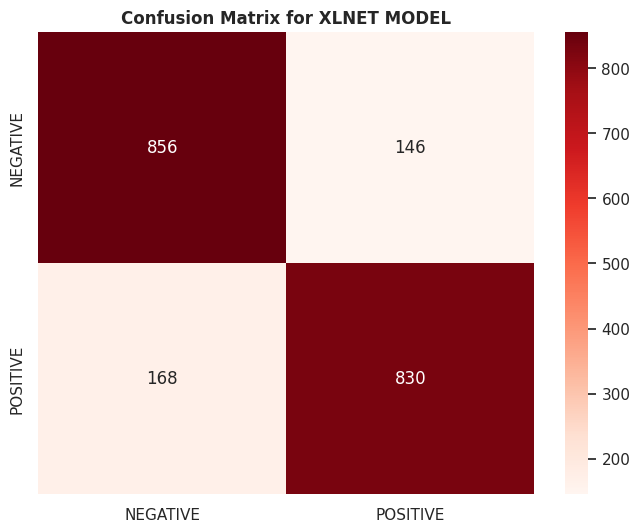

In [93]:

print_model_perfomance(labels_xlnet, preds_xlnet, "XLNET MODEL")

In [94]:
print(classification_report(
    pd.Series(preds_xlnet).map({1:"Positive", 0:"Negative"}),
    pd.Series(labels_xlnet).map({1:"Positive", 0:"Negative"}))
     )

              precision    recall  f1-score   support

    Negative       0.85      0.84      0.85      1024
    Positive       0.83      0.85      0.84       976

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



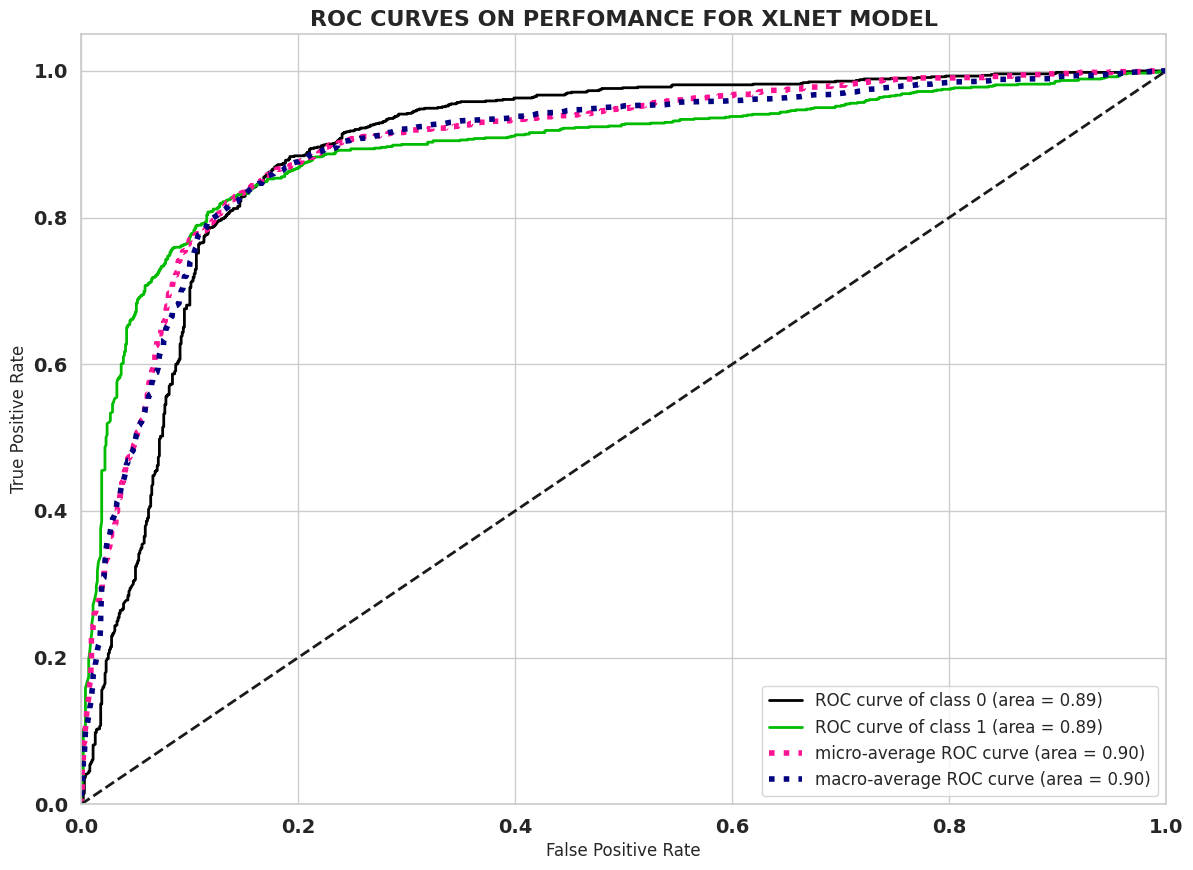

In [95]:
# plot ROC curve for the same
plot_roc_curves(labels_xlnet, probs_xlnet, "XLNET MODEL")

In [96]:
# sample
sample_to_test_inputs =  [
    "I absolutely loved the movie! It was so engaging and emotionally touching.",
    "The customer service was terrible. I had a terrible experience dealing with them.",
    "The weather today is beautiful, and I'm in a great mood!",
    "The food at the restaurant was disappointing. The taste and presentation were below expectations.",
    "The event was just okay. Nothing exceptional, but just the normal speakers we know speaking about AI and NLP.",
    "The new update to the app is neutral working well. I will be looking forward for feature improvements.",
    "The food at the restaurant was very disappointing. The taste and presentation were below expectations except for the fact that the place was very nice."
]

sentiment_labels = [
    "Positive sentiment",
    "Negative sentiment",
    "Positive sentiment",
    "Negative sentiment",
    "Neutral sentiment (Can Either be both)",  #used to just see what model will see
    "Neutral sentiment (Can Either be both)",
    "Negative sentiment",
]


In [97]:
MAX_LEN = 128

In [98]:
def tokenize_sample_inputs(model_tokenizer, sentence):
    return model_tokenizer.encode_plus(
            sentence,
            max_length=MAX_LEN,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )


# a function that takes a text input, tokenizer and model to return predictions
def predict_user_inputs(model, model_tokenizer, text_input):
    bert_sample1 = tokenize_sample_inputs(model_tokenizer, text_input)
    input_ids = bert_sample1['input_ids']
    attention_mask = bert_sample1['attention_mask']
    input_ids = input_ids.to(device).long()
    attention_mask = attention_mask.to(device).long()
    # make prediction
    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask)

    return {1:"Positive sentiment", 0:"Negative sentiment"}[outputs.argmax().tolist()], outputs.max().tolist()

In [99]:
# test the above
predict_user_inputs(BERT_MODEL, bert_tokenizer, "hi there, I'm very exited to be having you in this case.")

('Positive sentiment', 0.9996874332427979)

In [100]:
# let create a dictionary that will hold these results
test_results = {
    "TEXT INPUT":[],
    "EXPECT RESULT":[],
    "BERT OUT":[],
    "BERT PROB":[],
    "ROBERTA OUT":[],
    "ROBERTA PROB":[],
    "XLNET OUT":[],
    "XLNET PROB":[],
}

In [101]:
# first append the text inputs and their labels for testing
for i,text_input_sample in enumerate(sample_to_test_inputs):
    test_results["TEXT INPUT"].append(text_input_sample)
    test_results["EXPECT RESULT"].append(sentiment_labels[i])

test_results

{'TEXT INPUT': ['I absolutely loved the movie! It was so engaging and emotionally touching.',
  'The customer service was terrible. I had a terrible experience dealing with them.',
  "The weather today is beautiful, and I'm in a great mood!",
  'The food at the restaurant was disappointing. The taste and presentation were below expectations.',
  'The event was just okay. Nothing exceptional, but just the normal speakers we know speaking about AI and NLP.',
  'The new update to the app is neutral working well. I will be looking forward for feature improvements.',
  'The food at the restaurant was very disappointing. The taste and presentation were below expectations except for the fact that the place was very nice.'],
 'EXPECT RESULT': ['Positive sentiment',
  'Negative sentiment',
  'Positive sentiment',
  'Negative sentiment',
  'Neutral sentiment (Can Either be both)',
  'Neutral sentiment (Can Either be both)',
  'Negative sentiment'],
 'BERT OUT': [],
 'BERT PROB': [],
 'ROBERTA OU

In [102]:
# save a XLNET tokenizer
pd.to_pickle(xlnet_tokenizer, "xlnet_tokenizer.pkl")
pd.to_pickle(roberta_tokenizer, "roberta_tokenizer.pkl")
pd.to_pickle(bert_tokenizer, "bert_tokenizer.pkl")

In [103]:
# perfom validation for bert
for text_input_sample in sample_to_test_inputs:
    bert_res = predict_user_inputs(BERT_MODEL, bert_tokenizer, f"{text_input_sample}")
    #append these results to above dictionary
    test_results["BERT OUT"].append(bert_res[0])
    test_results["BERT PROB"].append(bert_res[1])


    # repeat for other models
    robert_res = predict_user_inputs(ROBERTA_MODEL, roberta_tokenizer, f"{text_input_sample}")
    #append these results to above dictionary
    test_results["ROBERTA OUT"].append(robert_res[0])
    test_results["ROBERTA PROB"].append(robert_res[1])

    xlnet_res = predict_user_inputs(XLNET_MODEL, xlnet_tokenizer, f"{text_input_sample}")
    #append these results to above dictionary
    test_results["XLNET OUT"].append(xlnet_res[0])
    test_results["XLNET PROB"].append(xlnet_res[1])




In [104]:
# check the results as a tabular format

pd.DataFrame(test_results)


,TEXT INPUT,EXPECT RESULT,BERT OUT,BERT PROB,ROBERTA OUT,ROBERTA PROB,XLNET OUT,XLNET PROB
0,I absolutely loved the movie! It was so engagi...,Positive sentiment,Positive sentiment,0.999970,Positive sentiment,0.999951,Positive sentiment,0.999981
1,The customer service was terrible. I had a ter...,Negative sentiment,Negative sentiment,0.999970,Negative sentiment,0.999950,Negative sentiment,0.999992
2,"The weather today is beautiful, and I'm in a g...",Positive sentiment,Positive sentiment,0.999969,Positive sentiment,0.999950,Positive sentiment,0.999986
3,The food at the restaurant was disappointing. ...,Negative sentiment,Negative sentiment,0.999964,Negative sentiment,0.999951,Negative sentiment,0.999992
4,"The event was just okay. Nothing exceptional, ...",Neutral sentiment (Can Either be both),Positive sentiment,0.972313,Negative sentiment,0.999952,Negative sentiment,0.999991
5,The new update to the app is neutral working w...,Neutral sentiment (Can Either be both),Positive sentiment,0.519944,Positive sentiment,0.999729,Negative sentiment,0.999990
6,The food at the restaurant was very disappoint...,Negative sentiment,Negative sentiment,0.999967,Negative sentiment,0.999951,Negative sentiment,0.999993


In [105]:
# !jupyter nbconvert --to html sentiment_analysis_new_updated_notebook.ipynb